# Dimensionality Reduction: the Notebook

The docs for many methods are available here:

http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition

Some particular sub-links:
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html#sklearn.decomposition.SparsePCA

In this notebook, I have a few tasks for you to try out related to PCA :)

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA

from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans 

from sklearn.datasets import make_swiss_roll
from sklearn.datasets import make_s_curve
from sklearn.datasets import make_circles

In [2]:
# a handy function for vizualizing principle components as a heatmap
# this allows you to see what dimensions in the 'original space' are
# active

def visualize_pca_comps_heatmap(plot, comps):
    heatmap = plot.pcolor(comps, cmap=plt.cm.Blues)
    
    x_lab = [i for i in range(comps.shape[1])]
    y_lab = [i for i in (range(comps.shape[0]))]
    
    plot.set_xticks(np.arange(comps.shape[1])+0.5, minor=False)
    plot.set_yticks(np.arange(comps.shape[0])+0.5, minor=False)
    
    # want a more natural, table-like display
    plot.invert_yaxis()
    
    plot.set_xticklabels(x_lab, minor=False)
    plot.set_yticklabels(y_lab, minor=False)
    
    plt.title('Heatmap of PCA components Rows: components, Cols: Original dimensions')

Explained variance ratio: 
 [0.52700549 0.47299451]
Cumulative explained variance: 
 [0.52700549 1.        ]
PCA components: 
 [[ 0.02389445  0.99971449]
 [-0.99971449  0.02389445]]


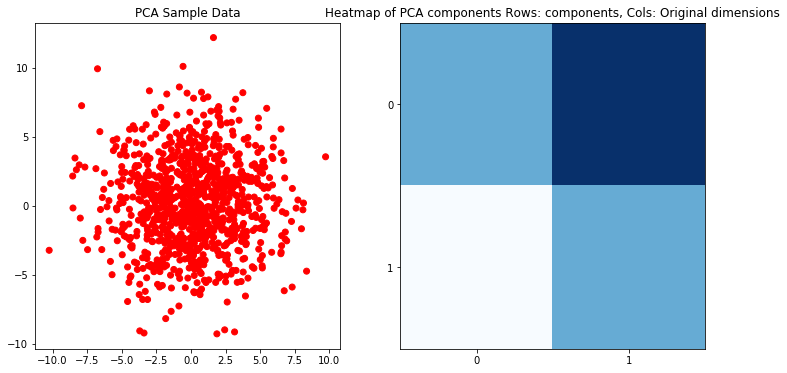

In [3]:
# small sample data set and PCA process
np.random.seed(42)

covar = 0
dat_low = np.random.multivariate_normal([0, 0], [[10, covar], [covar, 10]], 1000)

plt.figure(figsize=(12, 6))
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
p = plt.subplot(1, 2, 1)
p.scatter(dat_low[:, 0], dat_low[:, 1], 
          c=[1 for i in range(dat_low.shape[0])], cmap=cm_bright)
plt.title("PCA Sample Data")

n_comp = 2
pca_mod = PCA(n_components = n_comp)
pca_mod.fit(dat_low)

print ('Explained variance ratio: \n', pca_mod.explained_variance_ratio_) 
print ('Cumulative explained variance: \n', np.cumsum(pca_mod.explained_variance_ratio_))
print ('PCA components: \n', pca_mod.components_ )

p2 = plt.subplot(1, 2, 2)
visualize_pca_comps_heatmap(p2, pca_mod.components_)

## Task 1: PCA -- visualizing PCA and choosing the number of components

Some code is provided to correlated data in an arbitrary number of dimensions.

NOTE: Do not set the dimensions for make_correlated_data to anything less than 3

1. Use the independent data first. Plot the amount of explained variance vs the number of components. How can you use this chart to choose the number of componenets? Examine the function make_independent_data, look particularly at the covariance used to generate the data. Why is PCA making this choice?

2. Examine the principle components themselves. How can you tell which original dimensions are being used in the componenets? What changes as you switch between independent data and correlated data? What happens as you increase phi from a low value (e.g. 0.1) to a high value (e.g 0.9) when you generate correlated data?

3. Try the first question again with the correlated data.

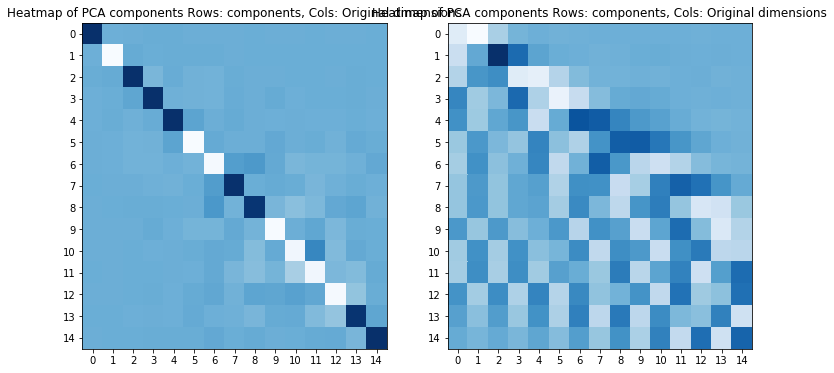

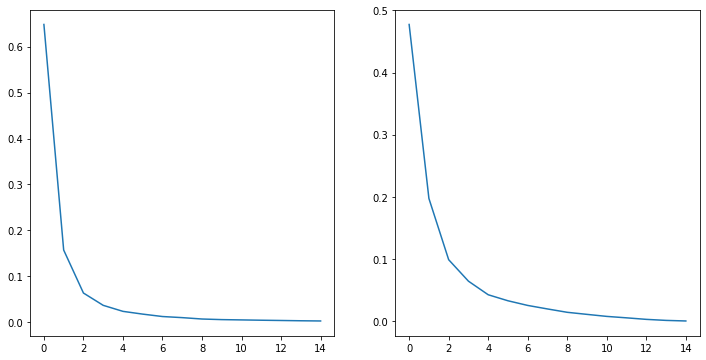

In [4]:
np.random.seed(42)

def make_independent_data(dimension=3, n=1000):
    '''
    Makes independent data in "dimension" dimensions
    '''
    covar = np.diag([10 / float( (i + 1) ** 2) for i in range(dimension)])
    dat_i = np.random.multivariate_normal([0 for i in range(dimension)], 
                                         covar, n)
    
    return dat_i

def make_correlated_data(dimension, phi=0.5, n=1000):
    '''
    Makes dependent data in "dimension" dimensions, correlation between
    index-adjacent dimensions controlled with "phi"
    NOTE: Phi must be between 0 and 1
    '''
    dat_i = make_independent_data(dimension, n)
    
    diag_D = np.concatenate([[1], [1 / np.sqrt(1 - phi**2) for i in range(dimension - 1)]])
    D = np.diag(diag_D)

    fc_L = np.concatenate([[1, phi], [0 for i in range(dimension-2)]])
    fr_L = np.concatenate([[1], [0 for i in range(dimension-1)]])

    L = sp.linalg.toeplitz(fc_L, fr_L)
    S = np.dot(D, L)
    
    dat_rotated = np.dot(dat_i, S)
    
    return dat_rotated


# generate some data
dat_independent = make_independent_data(15)
dat_rotated = make_correlated_data(15, phi=0.99)

### SOLUTION ~
n_comp = 15
plt.figure(figsize=(12, 6))

pca_mod = PCA(n_components = n_comp)
pca_mod.fit(dat_independent)
p2 = plt.subplot(1, 2, 1)
visualize_pca_comps_heatmap(p2, pca_mod.components_)

pca_mod_r = PCA(n_components = n_comp)
pca_mod_r.fit(dat_rotated)
p2 = plt.subplot(1, 2, 2)
visualize_pca_comps_heatmap(p2, pca_mod_r.components_)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(pca_mod.explained_variance_ratio_)
plt.subplot(1, 2, 2)
plt.plot(pca_mod_r.explained_variance_ratio_)

## Task 2: Non-linear Methods

1. Use the circles data. Plot the data, fit regular PCA to the data. Is this very effective? Why or why not?

2. Now try using KernelPCA instead. This is a little trickier than regular PCA; follow these steps:

2a: Fit Kernel PCA to the circles data using KernelPCA, try 5 components to start. Use the rbf kernel, with gamma = 1 (see the arguments in the documentation).

2b: The lambda___ values roughly correspond to the amount of explained variance. You'll need to normalize by their sum to get an idea of how much variance each component explains. How much variance do the number of componenets explain? Try adding more than 5 componenets: do these extra components add any value?

2c: It is not easy to see exactly what each component means in the original space, but we can look at the data points projected into the kernel PCA space. Use the lambda___ values to see this. Use visualize_pca_comps_heatmap to look at the lambda__ values (this is an n by n_comp matrix). Make a plot for both the inner and outer circle. Do you see any patterns?

If you have time, try this process on:

swiss roll data
http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_swiss_roll.html

s curve data
http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_s_curve.html#sklearn.datasets.make_s_curve

these don't have two pieces like the circle data, but have a simple nonlinear structure that can be captured with kernel PCA.

[[-0.35413107  0.9351958 ]
 [ 0.9351958   0.35413107]]
[[-0.35413107  0.9351958 ]
 [ 0.9351958   0.35413107]]
[0.50155192 0.49844808]
kernel PCA variance explained:  [32.00657487 31.80714189 28.67942685 11.84805347 11.79398246  3.63823464
  3.57004866  1.97495708  1.92291837  0.87269531]


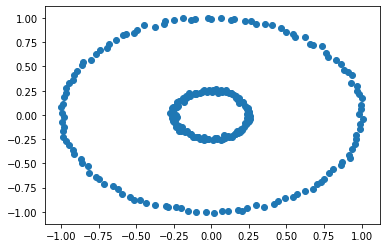

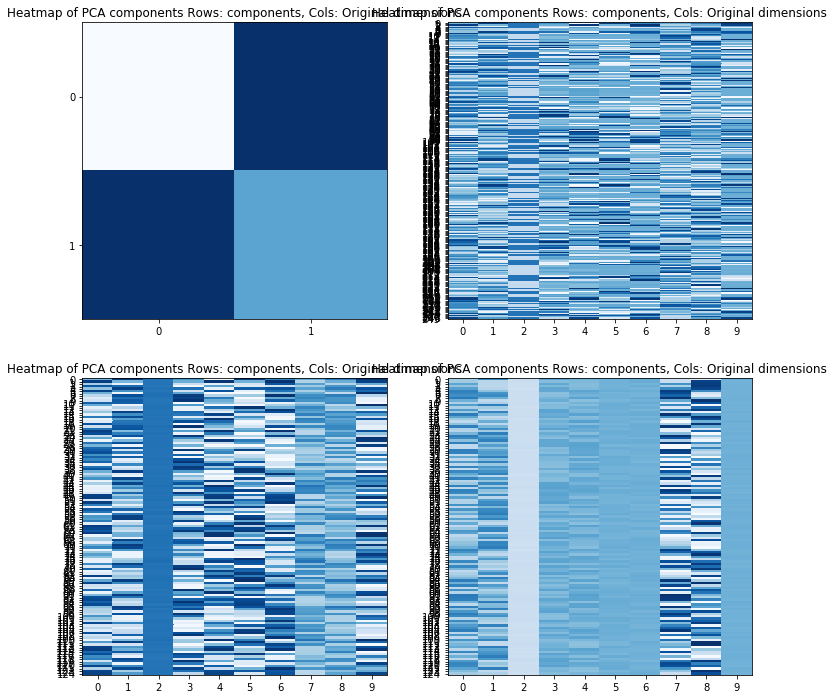

In [5]:
np.random.seed(42)

# make some circle data:
# dat_circles is the raw data, dat_circle label is a label indicating
# if the point is in the inner or outer circle (see the plot below)
dat_circles, dat_circle_label = make_circles(250, noise=0.01, factor=0.25)

# simple scatterplot of the data, so you get the idea ;)
plt.scatter(dat_circles[:, 0], dat_circles[:, 1])

## solutions:
n_comp = 2
plt.figure(figsize=(12, 12))

pca_mod = PCA(n_components = n_comp)
pca_mod.fit(dat_circles)
p2 = plt.subplot(2, 2, 1)
visualize_pca_comps_heatmap(p2, pca_mod.components_)

print (pca_mod.components_)

# not very useful! the components are just the two axes, how uninteresting
# further, the variance explained is 1/2 and 1/2. So, there's not really
# anything interesting going on here
print (pca_mod.components_)
print (pca_mod.explained_variance_ratio_)

kpca_mod = KernelPCA(n_components = 10, kernel='rbf', gamma=1)
kpca_mod.fit(dat_circles)

print ('kernel PCA variance explained: ', kpca_mod.lambdas_)
#print kpca_mod.alphas_

p2 = plt.subplot(2, 2, 2)
visualize_pca_comps_heatmap(p2, kpca_mod.alphas_)

p3 = plt.subplot(2, 2, 3)
visualize_pca_comps_heatmap(p3, kpca_mod.alphas_[dat_circle_label==0, :])
p4 = plt.subplot(2, 2, 4)
visualize_pca_comps_heatmap(p4, kpca_mod.alphas_[dat_circle_label==1, :])


## Task 3: PCA vs Sparse PCA

PCA always uses all of the original dimensions. That is fine, but it does not explicitly tell us that we can drop some other ones. You don't get statements like: this component is really only these two original dimensions, with no emphasis on the remaining. Sparse PCA is capable of dropping dimensions. Let's check it out!

1. Use the independent data with extra dimensions. As given initially below, th means the first three dimensions The example code below runs PCA with 4 components on these data. What do you notice about which dimensions are used most in each component?

2. Now fit sparse PCA to the same data, again using 4 componenets. Try varying the alpha parameter. What can you get to happen here?

[[-3.99563764e-01  8.28450866e-01  3.91747883e-01  1.51372216e-02
  -1.74959627e-02  4.03894785e-03]
 [ 4.91099685e-02 -4.07312566e-01  9.11915637e-01 -4.43403548e-04
   9.65167175e-03 -1.09705959e-03]
 [ 9.15303572e-01  3.83389766e-01  1.21984189e-01  1.84654246e-02
  -2.52777742e-03 -2.03817162e-03]
 [-9.04904266e-03 -2.37326759e-02 -6.48035662e-03  9.12315238e-01
  -3.28880839e-01 -2.42551399e-01]]
[[-2976.18168394 -3065.04952949 -3034.09319979 -3054.09474568
  -3055.83501048 -3062.78198052]
 [   17.18713581  -114.64101318     0.             0.
      0.             0.        ]
 [    0.             0.           206.59862597     0.
      0.             0.        ]
 [ -209.45826616     0.             0.             0.
      0.             0.        ]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


array([6, 2, 1, 1])

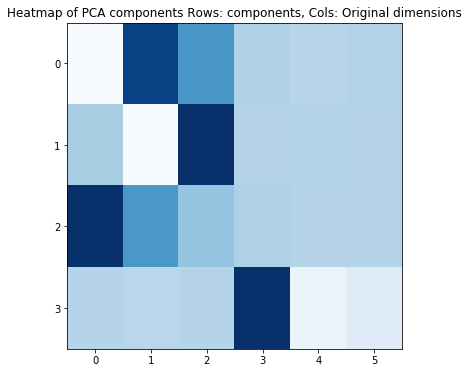

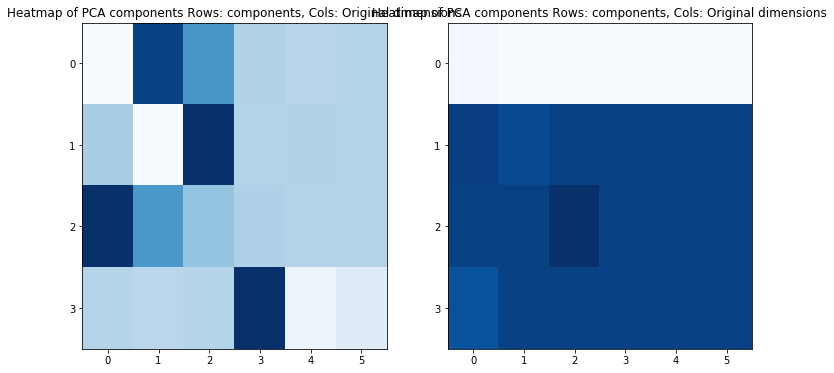

In [6]:
np.random.seed(42)

def make_independent_data(dimension=3, n=1000):
    '''
    Makes independent data in "dimension" dimensions
    '''
    covar = np.diag([10 / float( (i + 1) ** 2) for i in range(dimension)])
    dat_i = np.random.multivariate_normal([0 for i in range(dimension)], 
                                         covar, n)
    
    return dat_i

def make_independent_data_with_extra_dimensions(dimension=3, extra=1, n=1000):
    '''
    Makes independent data in "dimension" dimensions
    '''
    
    # if you have no extra dimensions, call on a previous function
    if extra == 0:
        return make_independent_data(dimension, n)
    covar_i = np.diag([100 for i in range(dimension)])
    covar_e = np.diag([10 for i in range(extra)])
    
    dat_i = np.random.multivariate_normal([100 for i in range(dimension)], 
                                         covar_i, n)
    dat_i_e = np.random.multivariate_normal([100 for i in range(extra)], 
                                            covar_e, n)
    
    return np.hstack((dat_i, dat_i_e))

def make_two_component_data_set(d_comp_1, d_comp_2, n=1000):
    comp_1 = np.zeros([d_comp_1, d_comp_1]) + 5
    comp_1 = comp_1 + np.diag([1 for i in range(d_comp_1)])
    
    comp_2 = np.zeros([d_comp_2, d_comp_2]) + 5
    comp_2 = comp_2 + np.diag([1 for i in range(d_comp_2)])
    
    covar = sp.linalg.block_diag(comp_1, comp_2)
    
    dat = np.random.multivariate_normal([0 for i in range(d_comp_1 + d_comp_2)],
                                        covar, n)
    
    return dat

    
dat = make_independent_data_with_extra_dimensions(3, 3)
dat_two_comp = make_two_component_data_set(2, 2)

plt.figure(figsize=(6, 6))
n_comp = 4
pca_mod = PCA(n_components = n_comp)
pca_mod.fit(dat)
p1 = plt.subplot(1, 1, 1)
visualize_pca_comps_heatmap(p1, pca_mod.components_)

# python hint: find the number of nonzero values per row / column:
# np.sum(mat != 0, 1) <- per row

## solutions:

plt.figure(figsize=(12, 6))
n_comp = 4
pca_mod = PCA(n_components = n_comp)
pca_mod.fit(dat)

p1 = plt.subplot(1, 2, 1)
visualize_pca_comps_heatmap(p1, pca_mod.components_)

# change alpha and watch as dimensions get dropped
spca = SparsePCA(n_components = n_comp, alpha=100, tol=0.1)
spca.fit(dat)

p2 = plt.subplot(1, 2, 2)
visualize_pca_comps_heatmap(p2, spca.components_)

print (pca_mod.components_)
print (spca.components_)
np.sum(spca.components_ != 0 * 1, 1)